## 目的

マルチヘッドアテンションの構築方法を確認する。



# 背景

通常の単一のAttentionでは、
全ての単語の関連度を 1つの重み行列（W_Q, W_K, W_V） で計算します。
つまり「1種類の関係性」しか学べません。

たとえば文章中で：

“The cat sat on the mat.”

あるヘッドは「文法的な関係」(主語と動詞) に注目したい

別のヘッドは「意味的な関係」(cat ↔ mat) に注目したい
→ 1ヘッドではそれを両立できません。

## 概要

通常の（シングル）Attentionでは、

各単語に対して 1種類の「注目パターン」 しか学習できません。
例：「主語がどこか」「目的語がどこか」など。

しかし言語や時系列の構造には、

文法的関係（主語–動詞）

意味的関係（形容詞–名詞）

文脈的関係（遠い依存関係）
など、複数の観点の関連が同時に存在します。

👉 そこで登場するのが Multi-Head Attention です。


## 仕組みの概要

マルチヘッドアテンションでは、
Q, K, Vをそれぞれ複数の異なる重み行列で変換し、複数の「ヘッド」ごとにAttentionを計算します。

## Multiヘッド VS Singleヘッド
マルチヘッドアテンションとセルフアテンションのみの場合、一般的にマルチヘッドアテンションの方が精度は高くなりますが、その差はタスクやモデルの規模によって異なります。

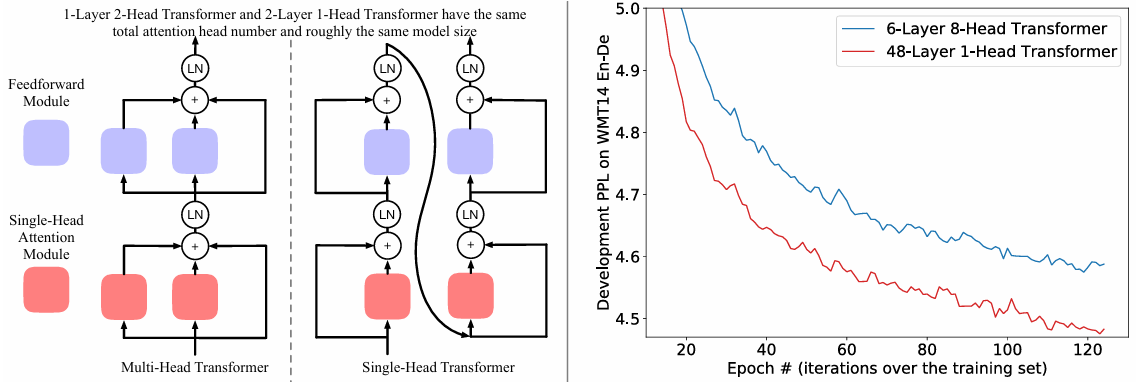

## マルチヘッドアテンションの作り方



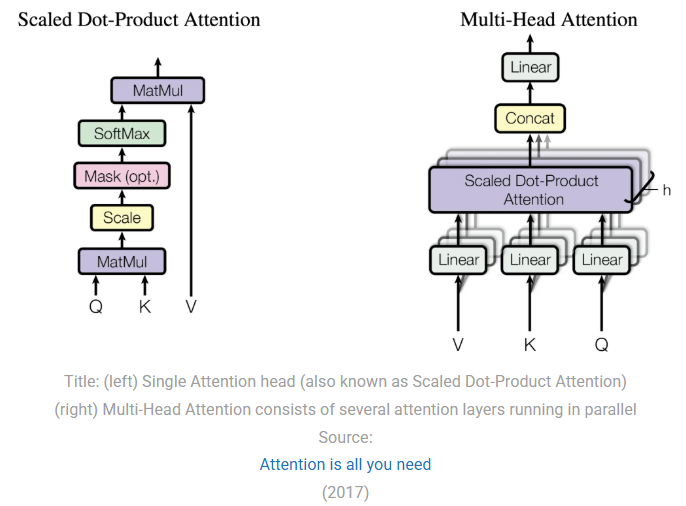

## 参照

https://apxml.com/courses/how-to-build-a-large-language-model/chapter-10-implementing-transformer-from-scratch/building-multi-head-attention-layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, num_heads, dropout=0.0):
    """
    embed_dim: 入力埋め込み次元 (d_model)
    num_heads: ヘッド数 h
    head_dim = embed_dim // num_heads が整数であることが前提
    """
    super().__init__()
    assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads

    # 線形投影：Q, K, V 用
    self.q_lin = nn.Linear(embed_dim, embed_dim)
    self.k_lin = nn.Linear(embed_dim, embed_dim)
    self.v_lin = nn.Linear(embed_dim, embed_dim)

    # 出力を結合した後の線形変換
    self.out_lin = nn.Linear(embed_dim, embed_dim)

    self.dropout = nn.Dropout(dropout)

  def __split_heads(self, x):
    b, seq, _ = x.size()
    x = x.view(b, seq, self.num_heads, self.head_dim)
    return x.permute(0, 2, 1, 3)

  def __combine_heads(self, x):
    b, _, seq, _ = x.size()
    # 元の形: (batch, num_heads, seq_len, head_dim)
    # permute 後: (batch, seq_len, num_heads, head_dim)
    # テンソルを連続メモリに並び替え
    x = x.permute(0, 2, 1, 3).contiguous()
    return x.view(b, seq, self.embed_dim)

  def forward(self, query, key, value, mask=None):
    Q = self.q_lin(query)
    K = self.k_lin(key)
    V = self.v_lin(value)

    Q = self.__split_heads(Q)
    K = self.__split_heads(K)
    V = self.__split_heads(V)
    # 2) スケールド・ドットプロダクトを計算
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

    # 3) マスク（あれば）を適用
    if mask is not None:
        # mask が bool なら True をマスク（値を -inf に）
        # ここでは mask==True の位置をマスクする前提
        # mask を (b, 1, seq_q, seq_k) などにしておくとブロードキャストされる
        scores = scores.masked_fill(mask, float('-inf'))

    attn = F.softmax(scores, dim=-1)
    attn = self.dropout(attn)

    context = torch.matmul(attn, V)

    out = self.__combine_heads(context)
    out = self.out_lin(out)

    return out, attn

In [ ]:
batch = 2
seq_q = 5
seq_k = 7
d_model = 32
heads = 4

mha = MultiHeadAttention(embed_dim=d_model, num_heads=heads, dropout=0.1)

q = torch.randn(batch, seq_q, d_model)
k = torch.randn(batch, seq_k, d_model)
v = torch.randn(batch, seq_k, d_model)

# 例: 単純なマスク (ここでは何もマスクしない)
mask = None

out, attn = mha(q, k, v, mask=mask)
print("out shape:", out.shape)      # (batch, seq_q, d_model)
print("attn shape:", attn.shape)    # (batch, num_heads, seq_q, seq_k)

out shape: torch.Size([2, 5, 32])
attn shape: torch.Size([2, 4, 5, 7])


## multi-head attentionアルゴリズム

入力データの準備:
FlashAttentionと同様に、入力シーケンスをトークン化し、ベクトル表現に変換します。

クエリ、キー、バリューの生成:
クエリ行列（Q）、キー行列（K）、バリュー行列（V）を生成します。

注意の分割:
MLAでは、注意を複数のヘッドに分割します。例えば、8つのヘッドに分割する場合、各ヘッドは異なる重み行列を持ち、それぞれ異なる特徴を捉えます。

各ヘッドでの注意計算:
各ヘッドごとに注意重みを計算し、バリュー行列に適用します。この時、MLAは効率的なメモリ使用と計算を実現します。

ヘッドの結合:
各ヘッドからの出力を結合し、最終的な出力を生成します。これにより、異なる注意パターンを統合した情報を得ることができます。

出力の生成:
最終的な出力は、ヘッドの結合結果をもとに、次の層への入力として使用されます。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 変数の設定
embed_dim = 512
num_heads = 8
batch_size = 16
seq_len = 100

必要なネットワークはすべて全結合層

In [2]:
q_proj = nn.Linear(embed_dim, embed_dim)
k_proj = nn.Linear(embed_dim, embed_dim)
v_proj = nn.Linear(embed_dim, embed_dim)

out_proj = nn.Linear(embed_dim, embed_dim)

In [3]:
# 入力データの準備
q_data = torch.rand(batch_size, seq_len, embed_dim)
k_data = torch.rand(batch_size, seq_len, embed_dim)
v_data = torch.rand(batch_size, seq_len, embed_dim)

QKVを計算する

In [5]:
batch_size = q_data.shape[0]

Q = q_proj(q_data)
K = k_proj(k_data)
V = v_proj(v_data)